Here, I will try to model stars hosting exoplanets. To do so, I will use the entire dataset of stars I have, with roughly a million stars, with only a few of them being labelled. 

To tackle this issue of a lack of labelled data, I will use a OneClassSVM unsupervised model, which is used for Outlier Detection.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score

pd.set_option('display.max_columns', None)

Importing the desired data

In [2]:
df = pd.read_csv('data/at_hyg_data.csv')

In [4]:
df.drop(['id', 'hip', 'hd', 'hyg', 'mag_src'], axis=1, inplace=True)

I drop missing values from the locations as I cannot impute coordinates.

In [35]:
df.dropna(subset=['vx', 'vy', 'vz', 'x0', 'y0', 'z0'], inplace=True)

The Spect variable has a lot of labels, as well as a lot of missing values. Because of that, I will use a frequency encoder, that will encode each label including the missing ones.
The High Multiplanetary and spect_src variables will be encoded with one-hot encoder.

For numerical variables with missing values, I will use the MICE algorithm (ci and rv variables).

In [36]:
## Creation of the pipeline

# Columns for encodings
one_hot_cols = ["high_multiplanetary", 'spect_src', 'pos_src', 'dist_src']
frequency_cols = ['spect', 'con', 'rv_src', 'pm_src']
num_cols = ['ci', 'rv', 'ra', 'dec', 'dist', 'x0', 'y0', 'z0', 'mag', 'absmag', 'pm_ra', 'pm_dec', 'vx', 'vy', 'vz']

# Set NaNs to "no value"

df[one_hot_cols] = df[one_hot_cols].fillna('no value')
df[frequency_cols] = df[frequency_cols].fillna('no value')

# Preprocessor Transformer

# First pipeline for numerical values. It imputes them with MICE and scales them.
numerical_pipeline = Pipeline(
    steps=[
        ('mice_imputation', IterativeImputer(random_state=17, max_iter=10)),
        ('scaler', StandardScaler())]
)

# Second pipeline for categorical values. 

categorical_pipeline = Pipeline([
    ('encoder', ColumnTransformer(
        transformers=[
            ('one_hot', ce.OneHotEncoder(handle_missing='value', handle_unknown='value'), one_hot_cols),
            ('frequency', ce.CountEncoder(handle_missing='value', normalize=True, handle_unknown='value'), frequency_cols)
        ],
        remainder='passthrough'
    ))
])

# Combine the two pipelines and drop the remaining columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', categorical_pipeline, one_hot_cols + frequency_cols),
    ],
    remainder='passthrough'
)

One-class SVM learns a decision function for novelty detection. It classifies new data as similar or different to the training set.

For that, you need to feed it training data which are of a particular class, showing them what we are looking for.

Then, you show it the new data and it will say whether or not they belong to the same class as the training data or not.

In [37]:
# Training the model on "normal" data

# X_train = kind of values we are looking for
# X_test = also good values, just to see if it works fine
# X_new_data = different values

X_train = df[df['host_exoplanet'] == True].drop(['host_exoplanet'], axis = 1)

new_data = df[df['host_exoplanet'] == False].drop(['host_exoplanet'], axis = 1)

train_normal, test_normal = train_test_split(X_train, random_state=17, test_size=0.1)

In [38]:
X_train.shape

(751, 23)

In [39]:
train_normal.shape

(675, 23)

In [40]:
test_normal.shape

(76, 23)

In [41]:
# Fit preprocessor in train data

preprocessor.fit(train_normal)

prep_train=preprocessor.transform(train_normal)

after_col=list(preprocessor.named_transformers_['num'].get_feature_names_out())+list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out())

X_train_df = pd.DataFrame(prep_train, columns=after_col)
X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce')

In [42]:
# Transform in test_normal data

prep_test=preprocessor.transform(test_normal)

after_col=list(preprocessor.named_transformers_['num'].get_feature_names_out())+list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out())

X_test_df = pd.DataFrame(prep_test, columns=after_col)
X_test_df = X_test_df.apply(pd.to_numeric, errors='coerce')

In [43]:
# Transform in new data

prep_new_data=preprocessor.transform(new_data)

after_col=list(preprocessor.named_transformers_['num'].get_feature_names_out())+list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out())

new_data_df = pd.DataFrame(prep_new_data, columns=after_col)
new_data_df = new_data_df.apply(pd.to_numeric, errors='coerce')

In [44]:
train_normal_array = np.array(X_train_df)
test_normal_array = np.array(X_test_df)
new_data_array = np.array(new_data_df)

Guessing about 10% of stars have exoplanets similar to Earth : https://www.cambridge.org/core/books/abs/drake-equation/fraction-of-stars-with-planetary-systems-fp-1961-to-the-present/71DDE7F46C63543C4C0FD79A0DA4027D

Here, I'm fitting it on host stars as it's the only labelled one between the two classes of stars (host stars or not host stars). It will learn from it.

In [45]:
clf = OneClassSVM(nu=0.01, kernel='rbf', verbose=True)
clf.fit(train_normal_array)

[LibSVM]

OneClassSVM(nu=0.01, verbose=True)

In [46]:
normal_res = clf.predict(train_normal_array)

In [47]:
X_train_df['score'] = normal_res
X_train_df['true'] = [1]*len(X_train_df)

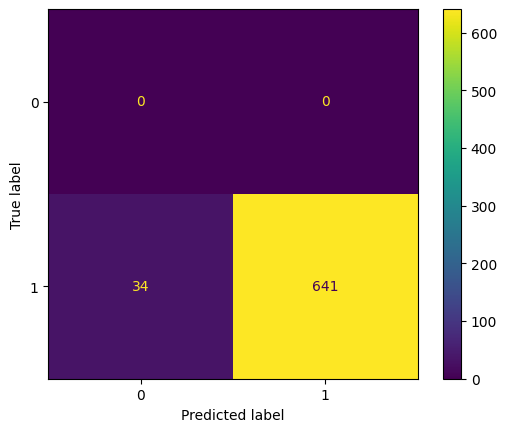

In [48]:
cm = confusion_matrix(y_true=X_train_df['true'], y_pred=X_train_df['score'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [49]:
normal_res = clf.predict(test_normal_array)

In [50]:
X_test_df['score'] = normal_res
X_test_df['true'] = [1]*len(X_test_df)

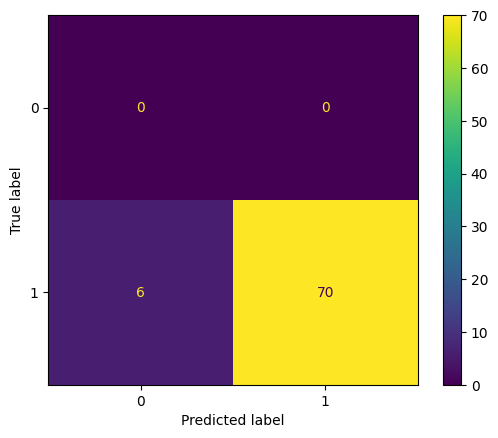

In [51]:
cm = confusion_matrix(y_true=X_test_df['true'], y_pred=X_test_df['score'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [52]:
attack_res = clf.predict(new_data_array)

In [53]:
new_data['score'] = attack_res

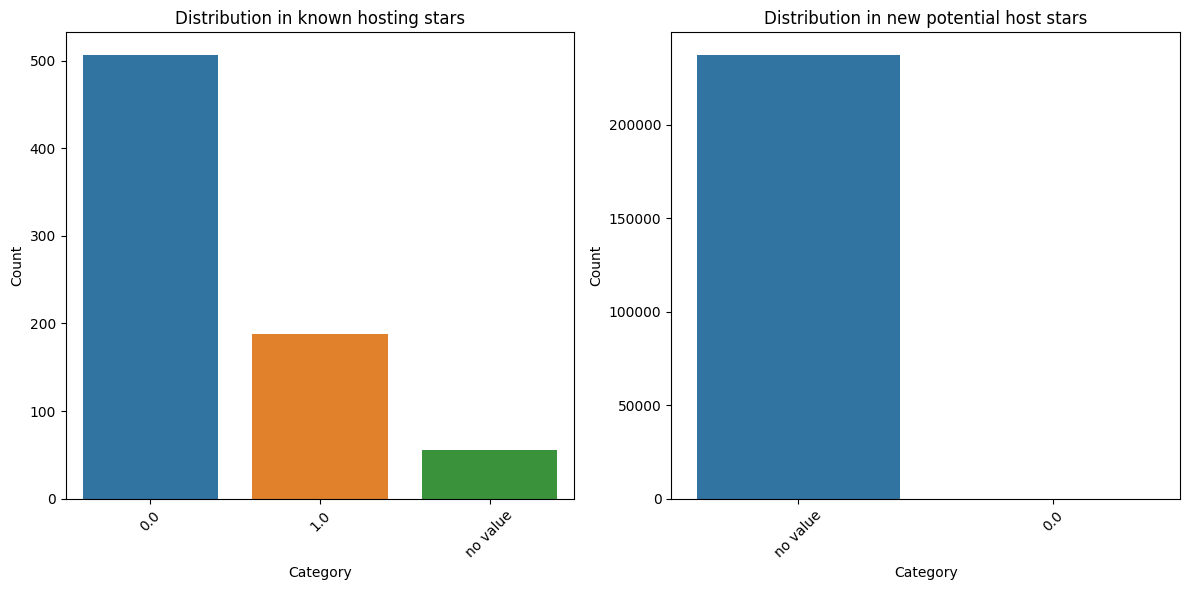

In [54]:
# Statistics on stars hosting NON Earth-like planets and comparison with potential Eath-Like Stars Host

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
sns.countplot(x='high_multiplanetary', data=X_train)
plt.title('Distribution in known hosting stars')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)  
sns.countplot(x='high_multiplanetary', data=new_data[new_data['score']==1])
plt.title('Distribution in new potential host stars')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

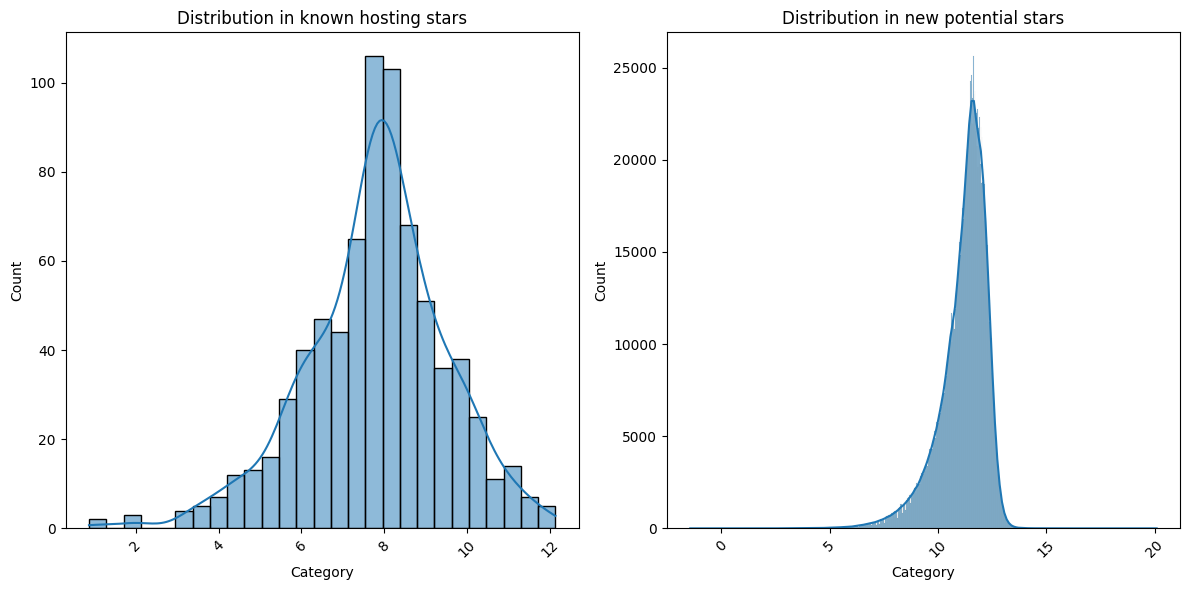

In [60]:
# Statistics on stars hosting Earth-like planets

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
sns.histplot(data=X_train, x='mag', kde=True) 
plt.title('Distribution in known hosting stars')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)  
sns.histplot(data=new_data, x='mag', kde=True) 
plt.title('Distribution in new potential stars')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_23164\3071236619.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap1 = sns.heatmap(X_train.corr(), cbar_kws={"shrink": 0.5}, square=True, vmin=-1, vmax=1, annot=True)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_23164\3071236619.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap2 = sns.heatmap(new_data[new_data['score']==1].corr(), cbar_kws={"shrink": 0.5}, square=True, vmin=-1, vmax=1, annot=True)


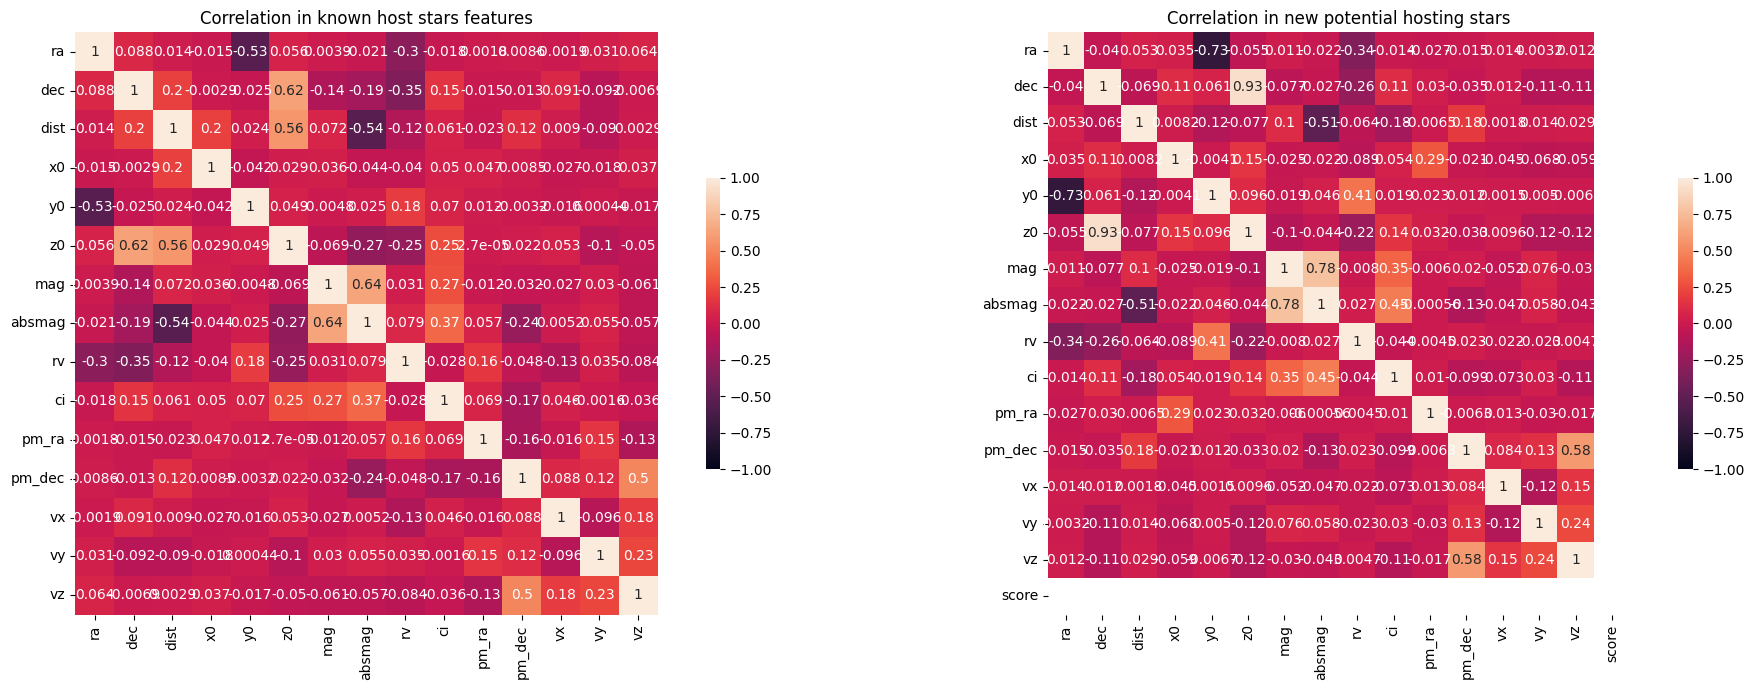

In [62]:
# Correlation differences

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1) 
heatmap1 = sns.heatmap(X_train.corr(), cbar_kws={"shrink": 0.5}, square=True, vmin=-1, vmax=1, annot=True)
heatmap1.set_title('Correlation in known host stars features')

plt.subplot(1, 2, 2)  
heatmap2 = sns.heatmap(new_data[new_data['score']==1].corr(), cbar_kws={"shrink": 0.5}, square=True, vmin=-1, vmax=1, annot=True)
heatmap2.set_title('Correlation in new potential hosting stars')

plt.tight_layout()
plt.show()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_23164\2544046783.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_X_train = X_train.corr().stack().reset_index(name='X_train')
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_23164\2544046783.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_newdata = new_data[new_data['score']==1].corr().stack().reset_index(name='newdata')


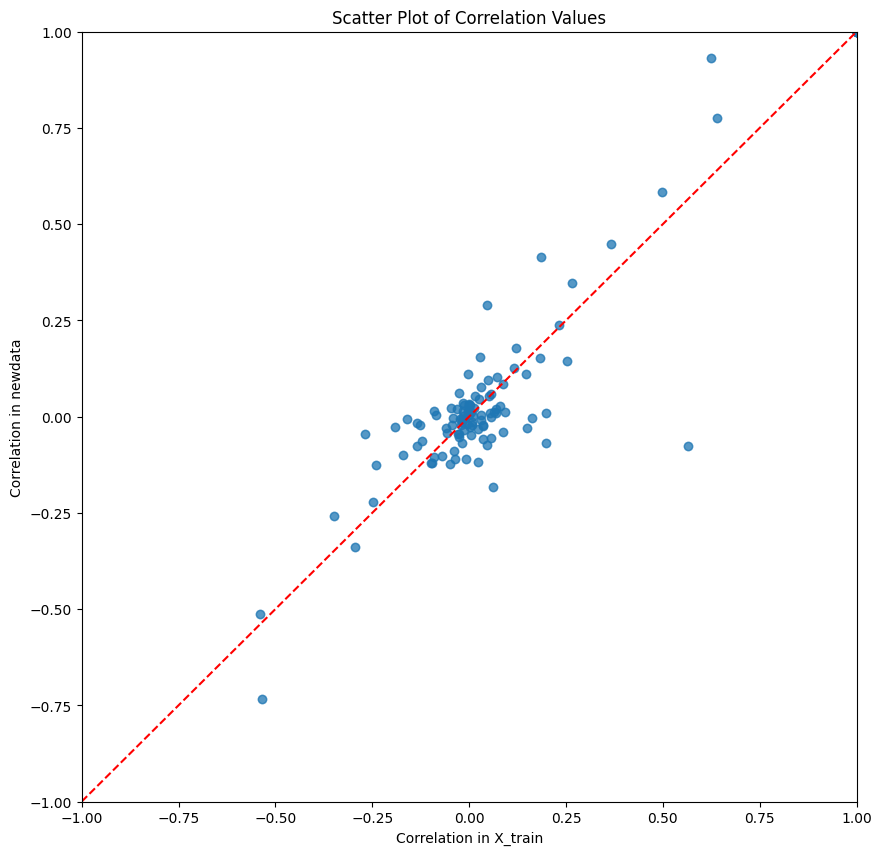

In [63]:
corr_X_train = X_train.corr().stack().reset_index(name='X_train')
corr_newdata = new_data[new_data['score']==1].corr().stack().reset_index(name='newdata')
correlation_comparison = pd.merge(corr_X_train, corr_newdata, on=['level_0', 'level_1'])

plt.figure(figsize=(10,10))
plt.scatter(correlation_comparison['X_train'], correlation_comparison['newdata'], alpha=0.5)
plt.xlabel('Correlation in X_train')
plt.ylabel('Correlation in newdata')
plt.title('Scatter Plot of Correlation Values')
plt.plot([-1, 1], [-1, 1], 'r--')  
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()